### Consumption Smoothing Models

Seho Jeong, Sogang University

References:
- **Kwak, Jun Hee. 2025.** "Lectures on Macroeconomics." Sogang University.
- **Sargent, Thomas J. and John Stachurski. n.d.** "Consumption Smoothing." A First Course in Quantitative Economics with Python. https://intro.quantecon.org/cons_smooth.html
- **Sargent, Thomas J., and John Stachurski. n.d.** "Optimal Savings I: Value Function Iteration." Quantitative Economics with JAX. https://jax.quantecon.org/opt_savings_1.html.
- **Sargent, Thomas J., and John Stachurski. n.d.** "Optimal Savings II: Alternative Algorithms." Quantitative Economics with JAX. https://jax.quantecon.org/opt_savings_2.html.

In [15]:
# Import libraries.

import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns 

from dataclasses import dataclass

from time import time
from tqdm.auto import tqdm

# from ..discretization.tauchen import tauchen
import quantecon as qe

In [3]:
jax.config.update('jax_enable_x64', True)

In [4]:
# Define customized colormap for plots.
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

#### Finite-Horizon Consumption-Savings Model

In [14]:
# Set parameters.
T = 60   # planning horizon
β = 0.96 # discount factor
R = 1.02 # gross interest rate
σ = 2.0  # CRRA
w = 1.0  # labor income; wage

# Set grids.
amin, amax, anum = 0.0, 10.0, 100
agrid = np.linspace(amin, amax, anum)

# Define felicity.
def u(c):
    """
    period utility function
    """
    if σ == 1:
        return np.where(c > 0, np.log(c), -np.inf)
    return np.where(c > 0, (c ** (1 - σ) - 1) / (1 - σ), -np.inf)

# Initialize value and policy functions.
V = np.zeros((T+2, anum))         
a_policy_idx = np.zeros((T+1, anum))

# Solve the problem using the backward induction.
for t in range(T, -1, -1):

    V_next = V[t+1]
    V_now = np.empty((anum, ))
    a_star_now = np.empty((anum, ))

    for ai, a in enumerate(agrid):

        c_vec = a * R + w - agrid   # consumption for every choice a_{t+1}
        RHS = u(c_vec) + β * V_next

        max_idx = RHS.argmax()      # index of maximizer a_{t+1}
        max_value = RHS[max_idx]    # maximized value RHS(a_{t+1})

        V_now[ai] = max_value
        a_star_now[ai] = max_idx    # store the index of optimal choices
    
    V[t] = V_now
    a_policy_idx[t] = a_star_now

# Translate indices into actual asset levels.
a_policy_val = agrid[a_policy_idx.astype(int)]

idx0 = np.searchsorted(agrid, 0.0)
print(f"c₀  = { (R)*0 + w - a_policy_val[0,idx0]:.3f}")
print(f"a₁* = { a_policy_val[0,idx0]:.3f}")

c₀  = 1.000
a₁* = 0.000


/var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1263/1524877125.py:19: RuntimeWarning: divide by zero encountered in reciprocal
  return np.where(c > 0, (c ** (1 - σ) - 1) / (1 - σ), -np.inf)


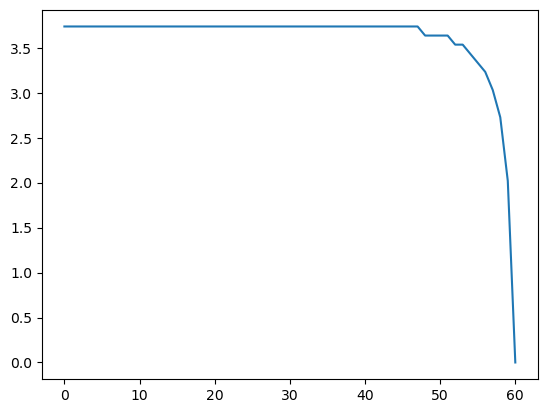

In [15]:
plt.plot(a_policy_val[:, 40])

#### Infinite-Horizon Consumption-Savings Model

Here we solve the following problem:

$$V(a, w) = \max_{a' \in [0, Ra + w]} \left\{ u(Ra + w - a') + \beta \mathbb E[V(a', w') \vert w]\right\}$$

where labor income $y$ follows a AR(1) process.

##### NumPy Version using Value Function Iteration

In [8]:
def create_consumption_model(R=1.01,   # gross interest rate
                            β=0.98,    # discount factor
                            γ=2,       # CRRA parameter
                            amin=0.01, # min. asset
                            amax=5.0,  # max. asset
                            anum=150,  # num. of grid points for asset
                            ρ=0.9,     # wage persistence
                            ν=0.1,     # wage volatility
                            wnum=100): # num. of grid points for wage
    """ 
    A function that takes in parameters and returns parameters and grids for the optimal savings problem
    """
    # Build grids and transition probabilities.
    agrid = np.linspace(amin, amax, anum)
    mc = qe.tauchen(n=wnum, rho=ρ, sigma=ν)
    wgrid, Q = np.exp(mc.state_values), mc.P

    # Pack and return
    params = β, R, γ
    sizes = anum, wnum
    arrays = agrid, wgrid, Q

    return params, sizes, arrays

In [9]:
def B(V, params, sizes, arrays):
    """ 
    A vectorized version of the RHS of the Bellman equation (before maximization), which is a 3D array representing

        B(a, w, a') = u(Ra + w - a') + β E[V(a', w') | w]
    
    for all (a, w, a').
    """
    # Unpack
    β, R, γ = params
    anum, wnum = sizes
    agrid, wgrid, Q = arrays

    # Compute current rewards r(a, w, ap) as array r[i, j, ip].
    a = np.reshape(agrid, (anum, 1, 1))  # a[i]   -> a[i, j, ip]
    w = np.reshape(wgrid, (1, wnum, 1))  # w[j]   -> w[i, j, ip]
    ap = np.reshape(agrid, (1, 1, anum)) # ap[ip] -> ap[i, j, ip]
    c = R * a + w - ap

    # Calculate continuation rewards at all combinations of (a, w, ap).
    V = np.reshape(V, (1, 1, anum, wnum)) # V[ip, jp] -> V[i, j, ip, jp]
    Q = np.reshape(Q, (1, wnum, 1, wnum)) # Q[j, jp]  -> Q[i, j, ip, jp]
    EV = np.sum(V * Q, axis=3)            # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return np.where(c > 0, (c ** (1 - γ)) / (1 - γ) + β * EV, -np.inf)

In [10]:
def T(V, params, sizes, arrays):
    """ 
    The Bellman operator
    """
    return np.max(B(V, params, sizes, arrays), axis=2)

In [11]:
def get_greedy(V, params, sizes, arrays):
    """
    Compute a v-greedy policy, returned as a set of indices.
    """
    return np.argmax(B(V, params, sizes, arrays), axis=2)

In [13]:
def value_function_iteration(model, max_iter=10_000, tol=1e-5):
    
    # Unpack the model
    params, sizes, arrays = model
    
    V = np.zeros(sizes)
    error = np.inf

    for iteration in tqdm(range(max_iter)):

        V_new = T(V, params, sizes, arrays)
        error = np.max(np.abs(V_new - V))
        V = V_new

        if error < tol:
            print(f'VFI completed in iteration {iteration}: error = {error}')
            break

    return V, get_greedy(V, params, sizes, arrays)

In [19]:
model = create_consumption_model()

print('Begin solving the model:')
start = time()
V_star, g_star = value_function_iteration(model)
end = time()
print(f'Total execution time: {end - start:.5f} seconds.')

# Save the execution time.
numpy_with_compile = end - start

Begin solving the model:


  0%|          | 0/10000 [00:00<?, ?it/s]

VFI completed in iteration 571: error = 9.884726907216645e-06
Total execution time: 3.16027 seconds.


In [26]:
# Unpack the model.
params, sizes, arrays = model
β, R, γ = params
anum, wnum = sizes
agrid, wgrid, Q = arrays

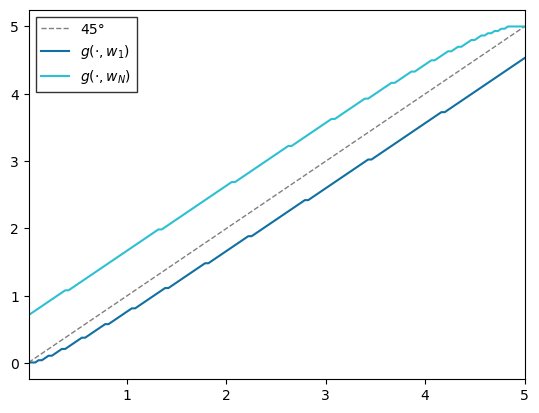

In [44]:
# Plot the policy function.
fig, ax = plt.subplots()

ax.plot(agrid, agrid, color='gray', ls='--', lw=1, label='45°')
ax.plot(agrid, agrid[g_star[:, 0]], label=r'$g(\cdot, w_1)$', color=cm[0])
ax.plot(agrid, agrid[g_star[:, -1]], label=r'$g(\cdot, w_N)$', color=cm[1])

ax.legend(fancybox=False, edgecolor='k')
ax.set_xmargin(0)

##### JAX Version using Value Function Iteration